In [1]:
# %env DRJIT_LIBLLVM_PATH /usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1
# !echo $DRJIT_LIBLLVM_PATH

In [2]:
# %%bash
# ln -sf /usr/lib/x86_64-linux-gnu/libstdc++.so.6 ${CONDA_PREFIX}/lib/libstdc++.so.6
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [1]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt
import time

mi.set_variant('cuda_ad_rgb')
# mi.set_variant('llvm_ad_rgb')

In [4]:
import polyscope as ps
from visualizer import plot_mesh, plot_mesh_attribute
import numpy as np

mesh_fp = "/home/jonathan/Documents/mi3-balance/resources/data/common/meshes/bunny.ply"
mesh_dict = {
    'type': 'ply',
    'filename': mesh_fp,
}

scene = mi.load_dict({
        "type": "scene",
        "myintegrator": {
            "type": "path",
            "max_depth": 10 # 5
        },
        "geo": mesh_dict,
    }
)

mesh = scene.shapes()[0]
mesh

PLYMesh[
  name = "bunny.ply",
  bbox = BoundingBox3f[
    min = [-0.0946899, 0.0329874, -0.0618736],
    max = [0.0610091, 0.187321, 0.0587997]
  ],
  vertex_count = 35947,
  vertices = [843 KiB of vertex data],
  face_count = 69451,
  faces = [814 KiB of face data],
  face_normals = 0
]

In [5]:
def make_si(mesh, scene):
    ps = mesh.sample_position(0.0, mi.Point2f(0.5, 0.5))
    ray = mi.Ray3f(ps.p, -ps.n)
    si = scene.ray_intersect(ray)
    return si

### Storage

In [6]:
from spherical_harmonics import get_sh_count, get_sh_order_from_index

# def get_sh_count(max_order: int):
#     return (max_order + 1) ** 2

# def get_sh_order_from_index(index: int):
#     return int(np.ceil(np.sqrt(index + 1) - 1))

def create_sh_buffer_scalar(mesh: mi.Mesh, max_order: int = 3):
    Nv = mesh.vertex_count()
    num_terms = get_sh_count(max_order)
    for index in range(num_terms):
        values = dr.full(Float, 0.5, Nv)
        mesh.add_attribute(
            name=f"vertex_sh_coeffs_{index}",
            size=1,
            buffer=values)

def create_sh_buffer_color(mesh: mi.Mesh, max_order: int = 3):
    Nv = mesh.vertex_count()
    num_terms = get_sh_count(max_order)
    for index in range(num_terms):
        values = mi.Color3f(
            dr.full(Float, 0.0, Nv), 
            dr.full(Float, 0.0, Nv), 
            dr.full(Float, 0.0, Nv))
        mesh.add_attribute(
            name=f"vertex_sh_coeffs_{index}",
            size=3,
            buffer=dr.ravel(values))

def create_bsdf_buffer(mesh: mi.Mesh, base_color, roughness: float):
    Nv = mesh.vertex_count()
    # handle color-valued attributes
    values = mi.Color3f(
        dr.full(Float, base_color[0], Nv), 
        dr.full(Float, base_color[1], Nv), 
        dr.full(Float, base_color[2], Nv))

    mesh.add_attribute(
        name="vertex_bsdf_color",
        size=3,
        buffer=dr.ravel(values))
    
    # handle scalar-valued attributes
    values = dr.full(Float, roughness, Nv)
    mesh.add_attribute(
        name="vertex_bsdf_scalar0",
        size=1,
        buffer=values)

create_sh_buffer_color(mesh, 2)
create_bsdf_buffer(mesh, [0.5, 0.5, 0.5], 0.1)
mesh

PLYMesh[
  name = "bunny.ply",
  bbox = BoundingBox3f[
    min = [-0.0946899, 0.0329874, -0.0618736],
    max = [0.0610091, 0.187321, 0.0587997]
  ],
  vertex_count = 35947,
  vertices = [5.07 MiB of vertex data],
  face_count = 69451,
  faces = [814 KiB of face data],
  face_normals = 0,
  mesh attributes = [
    vertex_bsdf_scalar0: 1 float,
    vertex_bsdf_color: 3 floats,
    vertex_sh_coeffs_5: 3 floats,
    vertex_sh_coeffs_4: 3 floats,
    vertex_sh_coeffs_8: 3 floats,
    vertex_sh_coeffs_3: 3 floats,
    vertex_sh_coeffs_2: 3 floats,
    vertex_sh_coeffs_6: 3 floats,
    vertex_sh_coeffs_1: 3 floats,
    vertex_sh_coeffs_7: 3 floats,
    vertex_sh_coeffs_0: 3 floats
  ]
]

In [7]:
si = make_si(mesh, scene)
print(mesh.eval_attribute_1("vertex_bsdf_scalar0", si))
print(mesh.eval_attribute_3("vertex_bsdf_color", si))
print(mesh.eval_attribute_3("vertex_sh_coeffs_2", si))

[0.1]
[[0.5, 0.5, 0.5]]
[[0, 0, 0]]


### Query (SH)

In [8]:
from spherical_harmonics import eval_sh_at_position

# Indexing convention
#
# order = 3
# for n in range(order+1):
#     for m in range(-n, n+1):
#         print(n, m)
#
# =====================
#    idx      n   m
# =====================
#     0:      0   0
#     1:      1   -1
#     2:      1   0
#     3:      1   1
#     4:      2   -2
#     5:      2   -1
#     6:      2   0
#     7:      2   1
#     8:      2   2
#     9:      3   -3
#     10:     3   -2
#     11:     3   -1
#     12:     3   0
#     13:     3   1
#     14:     3   2
#     15:     3   3

d = mi.Vector3f(dr.zeros(Float, 16), dr.zeros(Float, 16), dr.ones(Float, 16))
eval_sh_at_position(si, d)

[[0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0]]

### Fitting (SH)

16:	1.039505e-04
32:	4.768372e-06
64:	9.536743e-07
128:	0.000000e+00
256:	0.000000e+00
512:	9.536743e-07
16:	8.308887e-05
32:	2.384186e-07
64:	7.152557e-07
128:	5.364418e-07
256:	5.364418e-07
512:	5.960464e-07
Max error: 1.311e-06


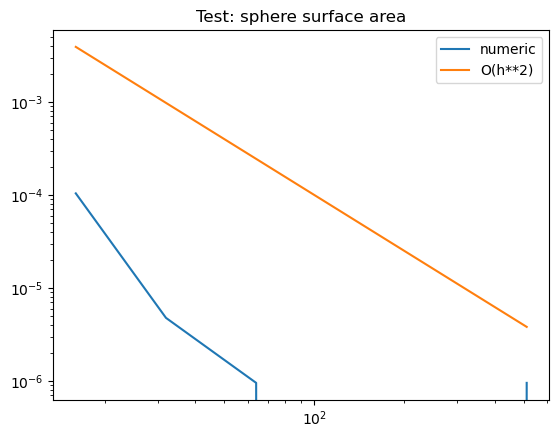

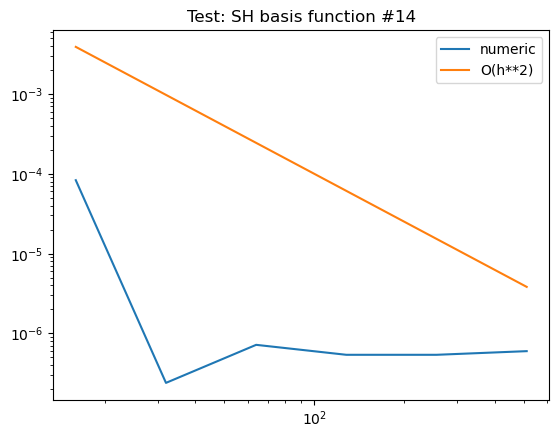

In [11]:
from spherical_harmonics_test import test_spherical_integrate_0, test_spherical_integrate_1, test_spherical_integrate_3

test_spherical_integrate_0()
test_spherical_integrate_1(14)

# # envmap = mi.load_dict({
# #     "type": "envmap",
# #     "filename": "/home/jonathan/Documents/mi3-balance/resources/data/common/textures/museum.exr"
# # })

test_spherical_integrate_3(3);

# TODO: fitting to a *hemisphere* for the radiance cache might require some care.
# - all measurement vectors should be duplicated and reflected about the z-axis
# - fit only the even SH basis functions (even wrt +-z, at least)

16:	1.297759e-02
32:	9.800121e-04
64:	4.663914e-04
128:	1.052469e-04
256:	3.413111e-05
512:	2.726167e-05
1024:	2.637506e-06


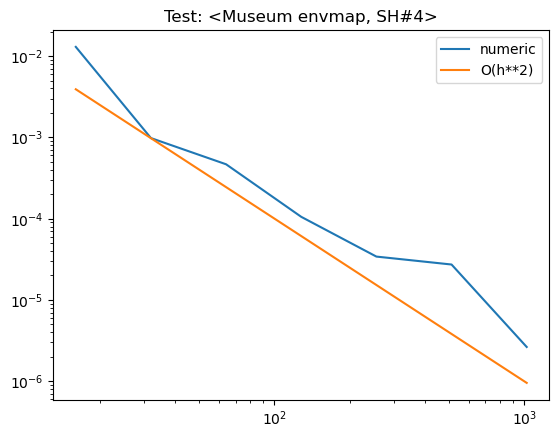

In [88]:
from spherical_harmonics_test import test_spherical_integrate_2

test_spherical_integrate_2(4)

In [42]:
from spherical_harmonics_test import test_fit_envmap, test_fit_sh

test_fit_envmap(9)
# test_fit_sh(9)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mean L2 error (color): [0.132947]


### Fitting on scene (SH)

In [125]:
scene = mi.load_file("/home/jonathan/Documents/mi3-balance/resources/data/scenes/cbox/cbox.xml")
integrator = scene.integrator()
sampler = mi.load_dict({'type': 'independent'})
meshes = scene.shapes()
mesh = meshes[0]

# Suppose we can somehow obtain position samples at each of the mesh vertices
Nv = mesh.vertex_count()
sampler.seed(0, Nv)
ps = mesh.sample_position(0, sampler.next_2d())

# Initialize interaction structs
si = dr.zeros(mi.SurfaceInteraction3f, Nv)
si.p, si.n = ps.p, ps.n
si.sh_frame = mi.Frame3f(ps.n)

d = dr.zeros(mi.Vector3f, 3)
d.z = 1


from spherical_harmonics import eval_basis
def fit(f_color, max_order: int, N: int = 64):
    d, sh_basis, quad_W = eval_basis(max_order, N)

    

    f_evals = f_color(d)
    integrand_R = quad_W * sh_basis * f_evals.x
    integrand_G = quad_W * sh_basis * f_evals.y
    integrand_B = quad_W * sh_basis * f_evals.z
    I_R = dr.ravel(dr.sum(integrand_R, axis=1))
    I_G = dr.ravel(dr.sum(integrand_G, axis=1))
    I_B = dr.ravel(dr.sum(integrand_B, axis=1))
    return mi.Color3f(I_R, I_G, I_B)




# def compute_Lo(si, d, spp = 64):
#     '''
#     Compute Lo
#     '''
#     rays = si.spawn_ray(-si.to_world(d))
#     num_rays = dr.width(d)
#     wide_idxs = dr.repeat(dr.arange(UInt, num_rays), spp)
#     rays_wide = dr.gather(mi.Ray3f, rays, wide_idxs)
#     colors, _, _ = integrator.sample(scene, sampler, rays_wide)
#     Lo = dr.block_reduce(dr.ReduceOp.Add, colors, block_size = spp) / spp
#     return Lo



# # mesh.vertex_position(dr.arange(UInt, mesh.vertex_count()))

# si = dr.zeros(mi.SurfaceInteraction3f, mesh.vertex_count())
# si.p = mesh.vertex_position(dr.arange(UInt, mesh.vertex_count()))
# for point in si.p:
#     fit_sh_coeffs_color(???, max_order=3, N=64)

SurfaceInteraction[
  t=[inf, inf, inf, inf, inf,    22 skipped .., inf, inf, inf, inf, inf],
  time=[0, 0, 0, 0, 0,    22 skipped .., 0, 0, 0, 0, 0],
  wavelengths=[],
  p=[[244.308, 548.3, 257.521],
     [282.459, 548.3, 264.814],
     [262.833, 548.3, 266.615],
     [342.015, 548.3, 329.02],
     [278.932, 548.3, 278.391],
        22 skipped ..,
     [240.244, 548.3, 250.799],
     [260.049, 548.3, 327.967],
     [284.283, 548.3, 295.701],
     [275.785, 548.3, 276.355],
     [226.503, 548.3, 230.571]],
  n=[[0, -1, 0],
     [0, -1, 0],
     [0, -1, 0],
     [0, -1, 0],
     [0, -1, 0],
        22 skipped ..,
     [0, -1, 0],
     [0, -1, 0],
     [0, -1, 0],
     [0, -1, 0],
     [0, -1, 0]],
  shape=[0x0, 0x0, 0x0, 0x0, 0x0,    22 skipped .., 0x0, 0x0, 0x0, 0x0, 0x0],
  uv=[[0, 0],
      [0, 0],
      [0, 0],
      [0, 0],
      [0, 0],
         22 skipped ..,
      [0, 0],
      [0, 0],
      [0, 0],
      [0, 0],
      [0, 0]],
  sh_frame=Frame[
             s=[[1, 0, -0],
     

### Query (BSDF)

In [11]:
# ps.init(); plot_mesh_attribute(mesh, "vertex_bsdf_color", True); ps.show()